Esta libreta adapta un algoritmo genetico enfocado en buscar las mejores combinaciones de caracteristicas para un SVM.

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#El modelo a usar:

from sklearn.svm import SVC

#Importamos el dataset
Debe estar ya limpio y con todas las variables numericas (ya con one hot encoding o label encoding)

In [ ]:
#Importamos el dataset
df=pd.read_csv('/content/ObesidadLimpia1.csv')
df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight_yes,SMOKE_yes,SCC_yes,FAVC_yes,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.522851,-0.875432,-0.862561,-0.784838,0.404376,-0.29881,-0.012314,-1.187312,0.562347,-1.418188,Normal weight,0,1,0,0,0,0,0,1,0
1,-0.522851,-1.950036,-1.168884,1.088434,0.404376,-0.29881,1.619759,2.339939,-1.079742,0.521474,Normal weight,0,1,1,1,0,0,0,1,0
2,-0.207656,1.058855,-0.364787,-0.784838,0.404376,-0.29881,-0.012314,1.164189,0.562347,2.461135,Normal weight,1,1,0,0,0,0,0,1,0
3,0.422733,1.058855,0.018116,1.088434,0.404376,-0.29881,-0.012314,1.164189,-1.079742,2.461135,Overweight level 1,1,0,0,0,0,0,0,0,1
4,-0.365253,0.843934,0.125329,-0.784838,-2.165781,-0.29881,-0.012314,-1.187312,-1.079742,0.521474,Overweight level 2,1,0,0,0,0,0,0,1,0


In [ ]:
#Separamos el target del resto de variables
X=df.drop(['NObeyesdad'],axis=1)
y=df['NObeyesdad']

#Algoritmo genetico

In [ ]:
#Este vector de nombres de variables sera el espacio sobre el que trabajaremos para optimizar
#El fin es seleccionar las variables que nos den la mejor accuracy (o puede ser otra metrica)
Variables=X.columns
Variables

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE',
       'CALC', 'Gender_Male', 'family_history_with_overweight_yes',
       'SMOKE_yes', 'SCC_yes', 'FAVC_yes', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')

In [ ]:
#El primer paso es crear vectores iniciales aleatorios, se dice que el numero indicado  es 5*D vectores iniciales , D es la cantidad de variables
NumVectores=5*X.shape[1]
VectoresIniciales=np.random.randint(0,2,size=(NumVectores,X.shape[1]))

In [ ]:
#ESTOS PARAMETROS SON LOS DEL ALGORITMO , LOS PODEMOS MODIFICAR
ProbCruce=0.9
ProbMut=0.1
Generaciones=3

In [ ]:
#ESTE DICCIONARIO ES CON EL QUE SE VA A HACER GRIDSEARCH, SE PASA EL PARAMETRO Y QUE SE QUIERE PROBAR

"""
Esta adaptacion incluye un posible uso de gridsearch y validacion cruzada. En algoritmos que son mas complejos
se recomienda usar una sola configuracion de parametros y pocos folders ya que se busca principalmente una buena
eleccion de caracteristicas dado ciertos parametros. En oros algoritmos como el KNN en el que es menos tardado se
puede utilizar gridsearch cob varias K para obtener un modelo final con muy buen fitness (dependiendo de si el dataset
lo permite)
"""

#Parametros del algoritmo:
Dict_Parametros={
    'C': [2],          # Control de margen (penalización)
    'kernel': ['linear'],  # Tipos de kernel
    #'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Parámetro de RBF y poly
    #'coef0': [0, 0.1, 0.5, 1],        # Parámetro adicional para kernel poly y sigmoid
}

#METRICA DE EVALUACION A OPTIMIZAR: accuracy . Se puede cambiar
scoring='accuracy'

#CUANTOS FOLDS PARA HACER LA VALIDACION CRUZADA USAR
cv=5

#EL TAMAÑO DE LA DIVISION EN EL TEST PRUEBA
test_size=0.2

#EL RANDOM STATE
random_state=35

## El algoritmo codificado

In [ ]:
from typing import Dict
#Esta es una funcion que en base a un vector binario me devuelve un vector de caracteristicas

def ObtenerCaracteristicas(Binario,caracteristicas):
    Caracteristicas=[]
    for i in range(len(Binario)):
        if Binario[i]==1:
            Caracteristicas.append(caracteristicas[i])
    return Caracteristicas

#En esta funcion hacemos la evaluacion del modelos, con gridsearch y validacion cruzada. Debe cambiarse dependiendo del metodo

def Evaluar(i,X,y,Parametros):

    Caracteristicas=ObtenerCaracteristicas(i,Variables)

    #Obtengo X con ellas
    X_train, X_test, y_train, y_test = train_test_split(X[Caracteristicas], y, test_size=test_size, random_state=random_state)

    # Crear el modelo SVM
    svm = SVC()

    # Definir los posibles valores de K a explorar
    param_grid = Dict_Parametros

    # Configurar la búsqueda en cuadrícula con validación cruzada de cv pliegues
    grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring=scoring)

    # Entrenar el modelo con búsqueda de hiperparámetros
    grid_search.fit(X_train, y_train)

    #La metrica que usamos es el promedio de los modelos que se hicieron en el cross validation
    promedio_puntajes = np.mean(grid_search.cv_results_['mean_test_score'])

    return promedio_puntajes,grid_search.best_params_

  #Paso 3: Hacemos la seleccion de dos padres que despues se van a cruzar
def Seleccion(VectoresIniciales):
  #Como la generacion actual puede tener individuos repetidos nos quedamos solamente con los unicos
  variables_unicas, indices_unicos = np.unique(VectoresIniciales, axis=0, return_index=True)

  # Me quedo tambien con las metricas de esos individuos unicos, este array de metricas tiene las accuracy del individuo en su misma posicion
  metricas_filtradas = Metricas[indices_unicos]

  #Ahora hago la ruleta
  Total=np.sum(metricas_filtradas)
  Probabilidades=metricas_filtradas/Total
  Probabilidades=np.cumsum(Probabilidades)

  #Creamos un numero entre 0 y 1 aleatorio

  N=np.random.random()

  #Hacemos a los padres usando probabilidad
  Padre1=None
  Padre2=None
  for i in range(len(Probabilidades)):
      if N<Probabilidades[i]:
          Padre1=variables_unicas[i]
          break
  N=np.random.random()
  for i in range(len(Probabilidades)):
      if N<Probabilidades[i]:
          Padre2=variables_unicas[i]
          break
  return Padre1,Padre2


#Paso 4: Hacemos el cruce de los papás

def Cruce(padre1, padre2, ProbCruce):
    # Generamos un número aleatorio entre 0 y 1 para determinar si se debe hacer el cruce
    if np.random.random() < ProbCruce:
        # Si la probabilidad es menor que la tasa de cruce, realizamos el cruce
        punto_cruce = np.random.randint(1, len(padre1)-1)  # Elegimos un punto aleatorio para el cruce (Claramente no puede ser ni 0 ni el ultimo)

        # Generamos los hijos intercambiando las partes antes y después del punto de cruce
        hijo1 = np.concatenate((padre1[:punto_cruce], padre2[punto_cruce:]))
        hijo2 = np.concatenate((padre2[:punto_cruce], padre1[punto_cruce:]))
    else:
        # Si no se hace cruce, los hijos son copias directas de los padres
        hijo1 = np.copy(padre1)
        hijo2 = np.copy(padre2)

    return hijo1, hijo2

#Paso 5: Vemos si habra mutacion
def Mutacion(hijo, ProbMut):
    for i in range(len(hijo)):
        # Generamos un número aleatorio entre 0 y 1 para determinar si mutamos el gen
        if np.random.random() < ProbMut:
            # Cambiamos el valor del gen, que es binario (0 o 1)
            hijo[i] = 1 - hijo[i]  # Cambiar 0 a 1 o 1 a 0
    return hijo


In [ ]:
def reemplazo_elitista(poblacion_actual, hijos_generados, fitness_poblacion, fitness_hijos, Parametros,ParametrosN,num_individuos_elites):
    # Paso 1: Combinar la población actual y los hijos generados
    poblacion_completa = np.concatenate((poblacion_actual, hijos_generados))
    fitness_completo = np.concatenate((fitness_poblacion, fitness_hijos))
    parametros_completo=np.concatenate((Parametros,ParametrosN))

    #print(poblacion_completa)
    #print(fitness_completo)
    #print(parametros_completo)

    # Paso 2: Ordenar la población completa por fitness (de mayor a menor), en ese mismo orden ponemos las accuracy y los parametros para no perderlos
    indices_ordenados = np.argsort(fitness_completo)[::-1]  # Ordena los índices de mayor a menor fitness
    #print(indices_ordenados)

    # Paso 3: Seleccionar los mejores individuos según el número de élites
    mejores_individuos = poblacion_completa[indices_ordenados[:num_individuos_elites]]
    #print(mejores_individuos)
    mejores_fitness = fitness_completo[indices_ordenados[:num_individuos_elites]]
    mejores_parametros = parametros_completo[indices_ordenados[:num_individuos_elites]]
    #print(mejores_parametros)

    # Paso 4: Seleccionar aleatoriamente el resto de la población para completar la nueva generación
    resto_individuos = poblacion_completa[indices_ordenados[num_individuos_elites:]]
    resto_fitness = fitness_completo[indices_ordenados[num_individuos_elites:]]
    resto_parametros = parametros_completo[indices_ordenados[num_individuos_elites:]]

    # Necesitamos completar la población con los mejores, por lo tanto elegimos el número restante
    num_faltantes = len(poblacion_actual) - num_individuos_elites

    individuos_restantes = resto_individuos[np.random.choice(len(resto_individuos), num_faltantes, replace=False)]

    indices = [np.where(np.all(resto_individuos == x, axis=1))[0][0] for x in individuos_restantes]

    #print(resto_individuos)
    #print(individuos_restantes)
    fitness_restantes = resto_fitness[indices]
    parametros_restantes = resto_parametros[indices]

    # Paso 5: Construir la nueva población
    nueva_poblacion = np.concatenate((mejores_individuos, individuos_restantes))
    nueva_fitness = np.concatenate((mejores_fitness, fitness_restantes))
    nueva_parametros = np.concatenate((mejores_parametros, parametros_restantes))

    return nueva_poblacion, nueva_fitness, nueva_parametros

In [ ]:

#Si encontramos un vector de puros ceros lo cambiamos por otro
for i in range(len(VectoresIniciales)):
    if np.array_equal(VectoresIniciales[i],np.zeros(X.shape[1])):
        while(True):
            VectoresIniciales[i]=np.random.randint(0,2,size=(1,X.shape[1]))
            if not np.array_equal(VectoresIniciales[i],np.zeros(X.shape[1])):
                break

#Paso 2: Obtenemos sus accuracy

Metricas=np.zeros(len(VectoresIniciales))
Parametros=np.empty(len(VectoresIniciales), dtype=object)

for i in range(len(VectoresIniciales)):
    Metricas[i],Parametros[i]=Evaluar(VectoresIniciales[i],X,y,Parametros)



for i in range(Generaciones):
  print(f"Generacion {i}")
  NuevaGeneracion=[]

  #Paso 3 4 5: Creamos una nueva generacion en base a seleccionar 2 papas, cruzarlos (a veces) y ver si el hijo muta (a veces)
  for i in range(round(len(VectoresIniciales)/2)):
    padre1,padre2=Seleccion(VectoresIniciales)
    hijo1,hijo2=Cruce(padre1,padre2,ProbCruce)
    hijo1=Mutacion(hijo1,ProbMut)
    hijo2=Mutacion(hijo2,ProbMut)

    #Checamos que los hijos no sean 0
    NuevaGeneracion.append(hijo1)
    NuevaGeneracion.append(hijo2)

  #Esto significa que la division no tiene sobrante
  if (len(VectoresIniciales)%2 == 1):
      NuevaGeneracion.append(NuevaGeneracion[-1])


  #Paso 6:
  #Calculamos las accuracy de esta nueva generacion
  MetricasN=np.zeros(len(NuevaGeneracion))
  ParametrosN=np.empty(len(NuevaGeneracion), dtype=object)

  for i in range(len(VectoresIniciales)):
      #Si el vector es de puros ceros lo penalizamos con metrica 0 y parametro vacio
      if np.array_equal(NuevaGeneracion[i],np.zeros(X.shape[1])):
          MetricasN[i]=0
          ParametrosN[i]={}
      else:
        #print(NuevaGeneracion[i])
        MetricasN[i],ParametrosN[i]=Evaluar(NuevaGeneracion[i],X,y,ParametrosN)

  #Paso 7: Seleccion, lo haremos por elitismo
  #Aqui obtenemos la nueva generacion, guardando las metricas y parametros. La nueva generacion se vuelve a guardad en vectores iniciales
  VectoresIniciales,Metricas,Parametros=reemplazo_elitista(VectoresIniciales,NuevaGeneracion,Metricas,MetricasN,Parametros,ParametrosN,3)

Generacion 0
Generacion 1
Generacion 2


# Resultados

In [ ]:
#Ordenamos las mejores combinaciones
indices_ordenados = np.argsort(Metricas)[::-1]

#Imprimimos las mejores configuraciones
for i in range(10):
  print(ObtenerCaracteristicas(VectoresIniciales[indices_ordenados[i]],Variables))
  print(Metricas[indices_ordenados][i])
  print(Parametros[indices_ordenados][i])
  print("/*-/*-/*-/*-/*-/*-/*-/*-/*-/*-/*- \n")

['Age', 'Height', 'Weight', 'NCP', 'FAF', 'TUE', 'Gender_Male', 'SCC_yes', 'FAVC_yes', 'MTRANS_Public_Transportation']
0.9585043808052254
{'C': 2, 'kernel': 'linear'}
/*-/*-/*-/*-/*-/*-/*-/*-/*-/*-/*- 

['Height', 'Weight', 'FCVC', 'FAF', 'TUE', 'Gender_Male', 'family_history_with_overweight_yes', 'SMOKE_yes', 'FAVC_yes', 'MTRANS_Motorbike', 'MTRANS_Walking']
0.9579126648288941
{'C': 2, 'kernel': 'linear'}
/*-/*-/*-/*-/*-/*-/*-/*-/*-/*-/*- 

['Height', 'Weight', 'CH2O', 'Gender_Male', 'family_history_with_overweight_yes', 'SMOKE_yes', 'SCC_yes', 'MTRANS_Bike']
0.9573209488525627
{'C': 2, 'kernel': 'linear'}
/*-/*-/*-/*-/*-/*-/*-/*-/*-/*-/*- 

['Height', 'Weight', 'NCP', 'CH2O', 'Gender_Male', 'family_history_with_overweight_yes', 'SMOKE_yes', 'SCC_yes', 'MTRANS_Bike']
0.9567309887099888
{'C': 2, 'kernel': 'linear'}
/*-/*-/*-/*-/*-/*-/*-/*-/*-/*-/*- 

['Age', 'Height', 'Weight', 'FCVC', 'CH2O', 'TUE', 'Gender_Male', 'SCC_yes', 'FAVC_yes', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Publi

In [ ]:
print("La mejor combinacion de variables es:")
print(ObtenerCaracteristicas(VectoresIniciales[indices_ordenados[0]],Variables))
print(f"Con un fit de {Metricas[indices_ordenados[0]]}")
print("Y sus parametros son:")
print(Parametros[indices_ordenados[0]])

La mejor combinacion de variables es:
['Age', 'Height', 'Weight', 'NCP', 'FAF', 'TUE', 'Gender_Male', 'SCC_yes', 'FAVC_yes', 'MTRANS_Public_Transportation']
Con un fit de 0.9585043808052254
Y sus parametros son:
{'C': 2, 'kernel': 'linear'}


In [ ]:
#Aqui hacemos un diccionario con las variables y que tantas veces aparecieron en las mejores combinaciones

# Inicializamos el diccionario
contador_variables = {}

# Iteramos sobre VectoresIniciales
for i in VectoresIniciales[:5]:
    # Obtenemos el array de características (nombres de variables)
    caracteristicas = ObtenerCaracteristicas(i, Variables)

    # Contabilizamos las veces que aparece cada variable
    for var in caracteristicas:
        if var in contador_variables:
            contador_variables[var] += 1  # Si la variable ya está, sumamos 1
        else:
            contador_variables[var] = 1   # Si no está, la agregamos con valor 1

# Imprimimos el diccionario con las frecuencias
contador_variables = dict(sorted(contador_variables.items(), key=lambda item: item[1], reverse=True))

print(contador_variables)

{'Weight': 5, 'Gender_Male': 5, 'Height': 4, 'FAF': 4, 'FAVC_yes': 4, 'Age': 3, 'NCP': 3, 'TUE': 3, 'SCC_yes': 3, 'FCVC': 3, 'family_history_with_overweight_yes': 3, 'SMOKE_yes': 3, 'MTRANS_Public_Transportation': 2, 'MTRANS_Motorbike': 2, 'MTRANS_Walking': 2, 'CH2O': 2, 'MTRANS_Bike': 1, 'CAEC': 1}


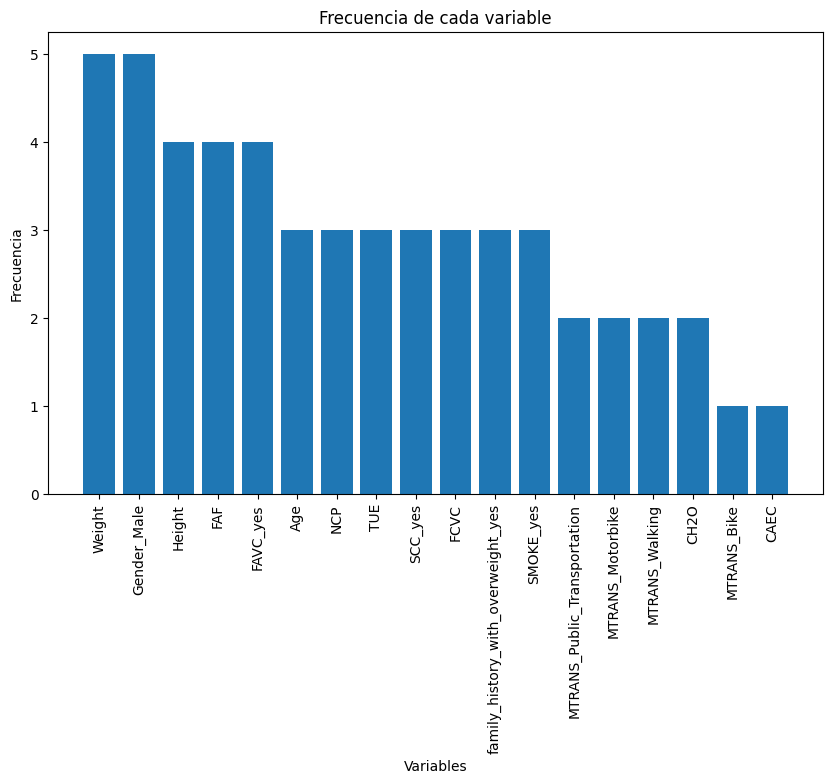

In [ ]:
#Imprimimos las frecuencias de las variables

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(list(contador_variables.keys()),contador_variables.values())
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de cada variable')
plt.show()